# Previsión de Falla

Los galpones de Full de mercado libre cuentan con una flota de dispositivos que transmiten
diariamente telemetría agregada en varios atributos.
Las técnicas de mantenimiento predictivo están diseñadas para ayudar a determinar la
condición del equipo de mantenimiento en servicio para predecir cuándo se debe realizar el
mantenimiento. Este enfoque promete ahorros de costos sobre el mantenimiento preventivo
de rutina o basado en el tiempo porque las tareas se realizan solo cuando están justificadas.

#### Entregable

El objetivo es generar un notebook Jupyter con un modelo para predecir la probabilidad de
falla del dispositivo un día antes de la posible falla, se debe utilizar una time series para
ayudar el modelo.
El archivo **full_devices.csv** tiene los valores diários para los 9 atributos de los dispositivos
y la columna que está tratando de predecir se llama 'failure' con el valor binario 0 para no
fallar y 1 para fallar, la colunas device tenes id del dispositivos.

------------

El notebook está estructurado en cinco partes:

**Parte 1: Análisis de los datos (EDA)**  
Aquí exploramos distribuciones, valores faltantes y correlaciones para entender el comportamiento de las variables.

**Parte 2: Procesamiento de datos para el modelado**  
Incluye extracción de características temporales, codificación de categorías y balanceo de clases.

**Parte 3: Ajuste del modelo**  
Entrenamos distintos clasificadores y seleccionamos la mejor configuración inicial.

**Parte 4: Optimización de modelos**  
Utilizamos Optuna para afinar los hiperparámetros de los algoritmos con base en F1-score.

**Parte 5: Cálculo de las probabilidades de fallo**  
Aplicamos el mejor modelo al conjunto de test para generar las probabilidades de falla al día siguiente.

-----
----

## 📚 Importando Bibliotecas

In [1]:
import warnings
import datetime
import inspect

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
from pathlib import Path


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, make_scorer)


from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, VotingClassifier
)


import optuna


## ⚙️ Funciones Utilizadas

In [2]:
def add_date_features(df):
    '''
    Agrega características temporales sin eliminar la columna 'date'.

    Args:
        df (pd.DataFrame): DataFrame con la columna 'date' en formato datetime.

    Returns:
        pd.DataFrame: copia de df con las siguientes columnas nuevas:
            - day_of_week: día de la semana (0=lunes … 6=domingo)
            - day_of_month: día del mes (1–31)
            - is_weekend: indicador de fin de semana (1 = sábado/domingo, 0 = día hábil)
            - month: mes del año (1–12)
            - week: número de semana ISO
        conservando la columna original 'date'.
    '''
    df = df.copy()
    df['day_of_week']  = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day
    df['is_weekend']   = (df['day_of_week'] >= 5).astype(int)
    df['month']        = df['date'].dt.month
    df['week']         = df['date'].dt.isocalendar().week
    
    return df


def undersample(X, y, random_state=42):
    '''
    Aplica undersampling para balancear las clases.

    Args:
        X: DataFrame con las variables predictoras.
        y: Series con la variable objetivo.
        random_state: semilla para reproducibilidad.

    Returns:
        X_res, y_res: arrays re-muestreados con la clase mayoritaria reducida.
    '''
    rus = RandomUnderSampler(random_state=random_state)
    X_res, y_res = rus.fit_resample(X, y)
    return X_res, y_res


def split_and_normalize(X, y, test_size=0.2, random_state=42):
    '''
    Divide los datos en entrenamiento y prueba, y estandariza las características.

    Args:
        X: array o DataFrame con las variables predictoras (ya balanceadas).
        y: array o Series con la variable objetivo (ya balanceada).
        test_size: proporción del conjunto para prueba.
        random_state: semilla para reproducibilidad.

    Returns:
        x_train_norm, x_test_norm, y_train, y_test: arrays listos para entrenamiento.
    '''
    x_train, x_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    scaler = StandardScaler()
    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm  = scaler.transform(x_test)
    return x_train_norm, x_test_norm, y_train, y_test


def evaluate_classifiers(x_train, y_train, x_test, y_test, classifiers=None):
    '''
    Treina e avalia vários classificadores no hold-out, retornando métricas.

    Args:
        x_train, y_train: treino.
        x_test, y_test: teste.
        classifiers: dict opcional {'nome': modelo}. Se None, usa defaults.

    Returns:
        DataFrame com Accuracy, Precision, Recall e F1-score, ordenado por F1.
    '''
    if classifiers is None:
        classifiers = {
            'GradientBoost': GradientBoostingClassifier(),
            'RandomForest':  RandomForestClassifier(),
            'BernoulliNB':   BernoulliNB(),
            'Regressão Log': LogisticRegression(),
            'SVM': SVC(),
            'KNN': KNeighborsClassifier()}

    results = []
    for name, clf in classifiers.items():
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        results.append({
            'Model': name,
            'Accuracy':  accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall':    recall_score(y_test, y_pred, zero_division=0),
            'F1-score':  f1_score(y_test, y_pred, zero_division=0)
        })

    return (pd.DataFrame(results)
            .sort_values('F1-score', ascending=False)
            .reset_index(drop=True))


def create_study(objective, n_trials=50, direction='maximize'):
    '''
    Crea y ejecuta un estudio de Optuna para optimizar hiperparámetros.

    Args:
        objective: función objetivo que recibe un trial y devuelve la métrica a maximizar.
        n_trials: número de iteraciones de búsqueda.
        direction: 'maximize' o 'minimize'.

    Returns:
        best_params: diccionario con los mejores hiperparámetros.
        best_value: valor óptimo alcanzado de la métrica objetivo.
    '''
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study.best_value


def objective_gb(trial, x_train, y_train, x_test, y_test):
    '''
    Función objetivo para optimizar GradientBoostingClassifier con Optuna.

    Args:
        trial: objeto Trial de Optuna.
        x_train, y_train: datos de entrenamiento.
        x_test, y_test: datos de prueba.

    Returns:
        F1-score en el conjunto de prueba.
    '''
    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 50, 500),
        'learning_rate':     trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth':         trial.suggest_int('max_depth', 3, 8),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
    }
    clf = GradientBoostingClassifier(**params, random_state=42)
    clf.fit(x_train, y_train)
    return f1_score(y_test, clf.predict(x_test))


def objective_rf(trial, x_train, y_train, x_test, y_test):
    '''
    Función objetivo para optimizar RandomForestClassifier con Optuna.

    Args:
        trial: objeto Trial de Optuna.
        x_train, y_train: datos de entrenamiento.
        x_test, y_test: datos de prueba.

    Returns:
        F1-score en el conjunto de prueba.
    '''
    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 10, 200),
        'max_depth':         trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
        'min_samples_leaf':  trial.suggest_float('min_samples_leaf', 0.1, 0.5),
        'max_features':      trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }
    clf = RandomForestClassifier(**params, random_state=42)
    clf.fit(x_train, y_train)
    return f1_score(y_test, clf.predict(x_test))


def objective_bnb(trial, x_train, y_train, x_test, y_test):
    '''
    Función objetivo para optimizar BernoulliNB con Optuna.

    Args:
        trial: objeto Trial de Optuna.
        x_train, y_train: datos de entrenamiento.
        x_test, y_test: datos de prueba.

    Returns:
        F1-score en el conjunto de prueba.
    '''
    params = {
        'alpha':     trial.suggest_loguniform('alpha', 1e-6, 1.0),
        'binarize':  trial.suggest_float('binarize', 0.0, 1.0),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False]),
    }
    clf = BernoulliNB(**params)
    clf.fit(x_train, y_train)
    return f1_score(y_test, clf.predict(x_test))


def train_model(params, model_cls, x_train, y_train, x_test, y_test, random_state=42):
    '''
    Ajusta y evalúa un clasificador, pasando random_state si aplica.

    Args:
        params: diccionario de parámetros para el modelo.
        model_cls: clase del modelo a instanciar.
        x_train, y_train: datos de entrenamiento.
        x_test, y_test: datos de prueba.
        random_state: semilla para reproducibilidad.

    Returns:
        model: instancia del modelo entrenado.
        f1: F1-score en el conjunto de prueba.
    '''
    sig = inspect.signature(model_cls.__init__).parameters
    if 'random_state' in sig:
        model = model_cls(**params, random_state=random_state)
    else:
        model = model_cls(**params)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    return model, f1_score(y_test, preds)


def build_voting(models_dict, voting='hard'):
    '''
    Crea un VotingClassifier a partir de un dict de modelos.

    Args:
        models_dict: diccionario {'nombre': modelo}.
        voting: 'hard' o 'soft'.

    Returns:
        VotingClassifier configurado.
    '''
    return VotingClassifier(estimators=list(models_dict.items()), voting=voting)


## 🧩 Parte 1:  Análisis de los Datos (EDA)

In [3]:
path = Path.cwd().parent / "data" / "full_devices.csv"
#---
df = pd.read_csv(path, sep=',', encoding='latin-1'); df['date'] = pd.to_datetime(df['date'])
df.tail()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0
124493,2015-11-02,Z1F0QLC1,0,17572840,0,0,0,10,351431,0,0,0


In [4]:
print('El número de filas es:', df.shape[0])
print('El número de columnas es:', df.shape[1])
print('-------------------------------')
df.info()

El número de filas es: 124494
El número de columnas es: 12
-------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124494 non-null  datetime64[ns]
 1   device      124494 non-null  object        
 2   failure     124494 non-null  int64         
 3   attribute1  124494 non-null  int64         
 4   attribute2  124494 non-null  int64         
 5   attribute3  124494 non-null  int64         
 6   attribute4  124494 non-null  int64         
 7   attribute5  124494 non-null  int64         
 8   attribute6  124494 non-null  int64         
 9   attribute7  124494 non-null  int64         
 10  attribute8  124494 non-null  int64         
 11  attribute9  124494 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


Todas las columnas están completas, sin valores nulos.

In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,124494,NaN,NaN,NaN,2015-04-16 05:20:49.737337088,2015-01-01 00:00:00,2015-02-09 00:00:00,2015-03-27 00:00:00,2015-06-17 00:00:00,2015-11-02 00:00:00,NaN
device,124494,1169,Z1F0QL3N,304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
failure,124494.0,NaN,NaN,NaN,0.000851,0.0,0.0,0.0,0.0,1.0,0.029167
attribute1,124494.0,NaN,NaN,NaN,122388103.242124,0.0,61284762.0,122797388.0,183309640.0,244140480.0,70459334.21636
attribute2,124494.0,NaN,NaN,NaN,159.484762,0.0,0.0,0.0,0.0,64968.0,2179.65773
attribute3,124494.0,NaN,NaN,NaN,9.940455,0.0,0.0,0.0,0.0,24929.0,185.747321
attribute4,124494.0,NaN,NaN,NaN,1.74112,0.0,0.0,0.0,0.0,1666.0,22.908507
attribute5,124494.0,NaN,NaN,NaN,14.222669,1.0,8.0,10.0,12.0,98.0,15.943028
attribute6,124494.0,NaN,NaN,NaN,260172.657726,8.0,221452.0,249799.5,310266.0,689161.0,99151.078547
attribute7,124494.0,NaN,NaN,NaN,0.292528,0.0,0.0,0.0,0.0,832.0,7.436924


El resumen estadístico indica lo siguiente:

* El dataset cuenta con 124.494 registros.
* Hay 304 fechas únicas y 1.169 dispositivos distintos.
* La variable `failure` está altamente desbalanceada: solo el 0,0851 % de los registros corresponden a fallas.
* Las variables `attribute2`, `attribute3`, `attribute4`, `attribute7`, `attribute8` y `attribute9` tienen una mediana igual a cero, lo que sugiere que, en muchos casos, no hubo actividad o los valores fueron nulos.
* `attribute1` y `attribute6` presentan valores medios elevados y una alta dispersión, lo que indica escalas muy diferentes.
* La variable `attribute5` muestra una distribución más regular, con valores entre 1 y 98, y una mediana cercana a 10.

In [6]:
df.drop_duplicates(inplace=True)
df.shape[0]

124493

🚨 Se detectó una fila duplicada en el conjunto de datos y fue eliminada.


In [7]:
df[df['failure'] == 1].device.nunique()

106

De los 1169 dispositivos listados en el conjunto de datos, solo 106 presentaron fallas.

Como queremos crear un modelo que prediga la probabilidad de falla para el día siguiente, vamos a desplazar la información un día.

In [8]:
df['target'] = df.groupby('device')['failure'].shift(-1)

Se creó la columna `device_model` extrayendo los primeros cuatro caracteres de la variable `device`, con el objetivo de agrupar los dispositivos por modelo y facilitar el análisis. Esto permite reducir la complejidad y observar el comportamiento por tipo de equipo, en lugar de por identificadores únicos.

In [9]:
df['device_model']=df['device'].apply(lambda x : x[:4])
df['device_model'].value_counts()

S1F0    33168
W1F0    23294
S1F1    21689
W1F1    19974
Z1F0    18869
Z1F1     7248
Z1F2      251
Name: device_model, dtype: int64

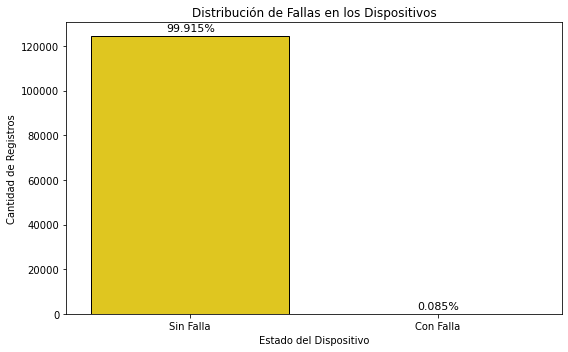

In [10]:
frecuencia_falla = df['failure'].value_counts().sort_index() 
total = frecuencia_falla.sum()
porcentajes = (frecuencia_falla / total * 100).round(3)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=['Sin Falla', 'Con Falla'],
    y=frecuencia_falla.values,
    palette=["#FFDD00", "#3A75C4"],
    edgecolor='black'
)

for i, (valor, pct) in enumerate(zip(frecuencia_falla.values, porcentajes)):
    ax.text(i, valor + total*0.01, f'{pct}%', ha='center', va='bottom', fontsize=11)

plt.xlabel('Estado del Dispositivo')
plt.ylabel('Cantidad de Registros')
plt.title('Distribución de Fallas en los Dispositivos')
plt.tight_layout()
plt.grid(False)
plt.show()


Como pocos dispositivos tuvieron fallas, es probable que los hayan reemplazado o cambiado por otros equipos con el correr del tiempo.
Por eso, vamos a hacer un análisis de cuántos dispositivos estuvieron activos a lo largo del tiempo y verificar si los que fallaron estuvieron presentes desde el comienzo del dataset.

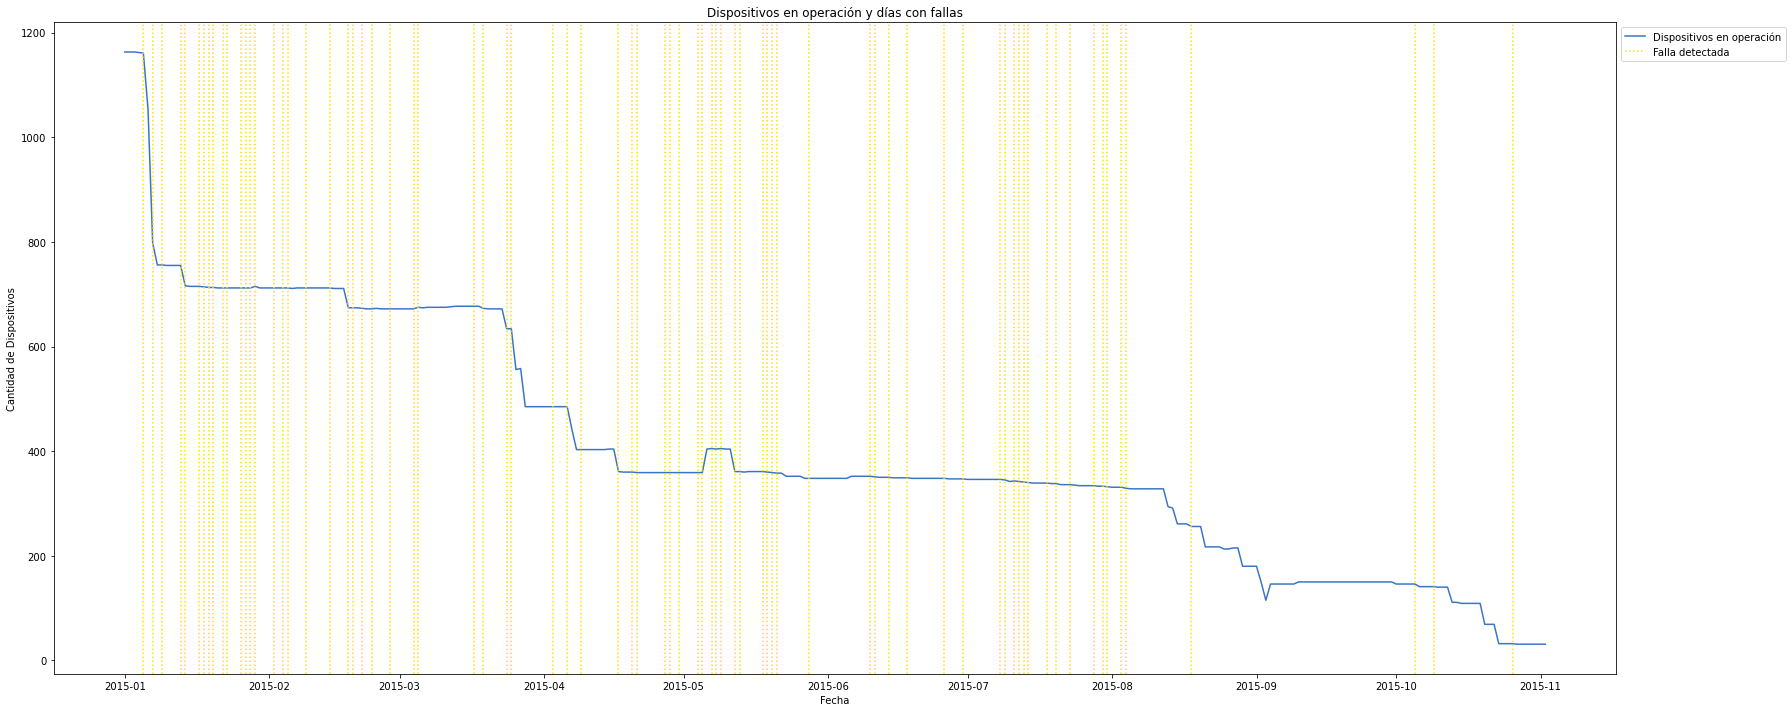

In [11]:
df_group = df.groupby('date').agg(count_devices=('device', 'count'), failure=('failure', 'max'))

# Plot
fig, ax = plt.subplots(figsize=(25, 10))
plt.plot(df_group.index, df_group['count_devices'], label='Dispositivos en operación', color="#3A75C4")

# Linhas falha
idx = df_group[df_group['failure'] == 1].index
for i in range(len(idx) - 1):
    plt.axvline(x=idx[i], linestyle='dotted', color="#FFDD00")

plt.axvline(x=idx[-1], color= '#FFDD00', linestyle='dotted', label='Falla detectada')

# Estilização
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Dispositivos')
plt.title('Dispositivos en operación y días con fallas')
plt.grid(False)
plt.tight_layout()
plt.show()


###  Análisis de los dispositivos en operación

En el gráfico se observa una **caída abrupta en la cantidad de dispositivos activos** entre enero y febrero, seguida de una disminución progresiva a lo largo del tiempo.

Las líneas amarillas marcan los días con fallas, pero se nota que esas fallas no generan una baja inmediata en el total de equipos en funcionamiento. Esto sugiere que los dispositivos con fallas fueron reemplazados o rotados, sin afectar el volumen operativo en el corto plazo.

Solo se detectan dos aumentos notorios en la cantidad de dispositivos: uno a principios de mayo y otro a principios de septiembre.
Como la cantidad inicial coincide con el total del dataset, no se incorporaron nuevos equipos, sino que hubo probablemente una rotación o baja progresiva.


### Consideración para el modelo

Como no se conoce la hora exacta de la medición en el día de la falla, se asumirá que la falla ocurre al día siguiente del último registro.
El modelo se va a construir con un día de anticipación, para permitir acciones preventivas a tiempo.



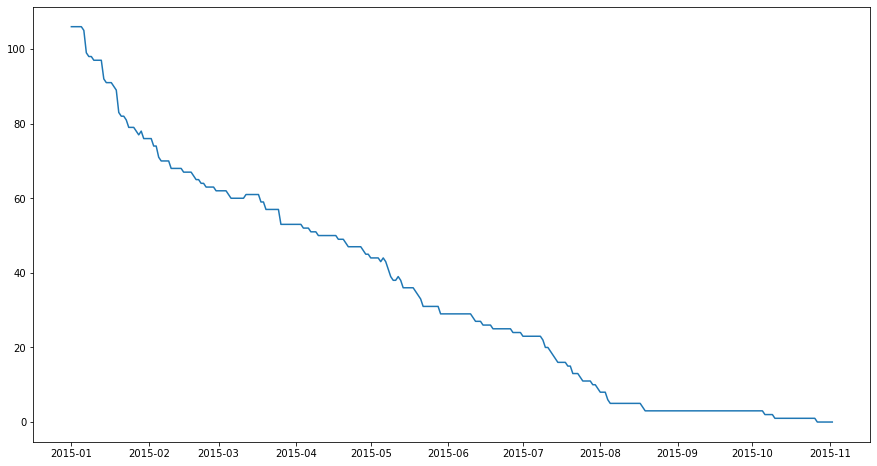

In [12]:
fail_list = df[df['failure'] == 1].device.unique()
aux = df.copy()
aux['fail_dev'] = aux['device'].agg(lambda x: 1 if x in fail_list else 0)

df_group = aux.groupby('date').agg(failure_devices = ('fail_dev', lambda x: np.sum(x>0)))
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(df_group.index,df_group['failure_devices'])

El gráfico muestra cómo evoluciona, a lo largo del tiempo, la cantidad de dispositivos que en algún momento presentaron una falla y que todavía seguían reportando datos en el conjunto.

Se observa una tendencia claramente descendente, lo que indica que, una vez que un dispositivo falla, es común que deje de estar activo en los registros posteriores. Esto sugiere que los dispositivos con fallas son retirados, reemplazados o desactivados progresivamente del sistema.

Esta información es clave para entender el comportamiento operativo y el ciclo de vida de los equipos, y resulta especialmente útil al momento de desarrollar modelos de predicción de fallas.


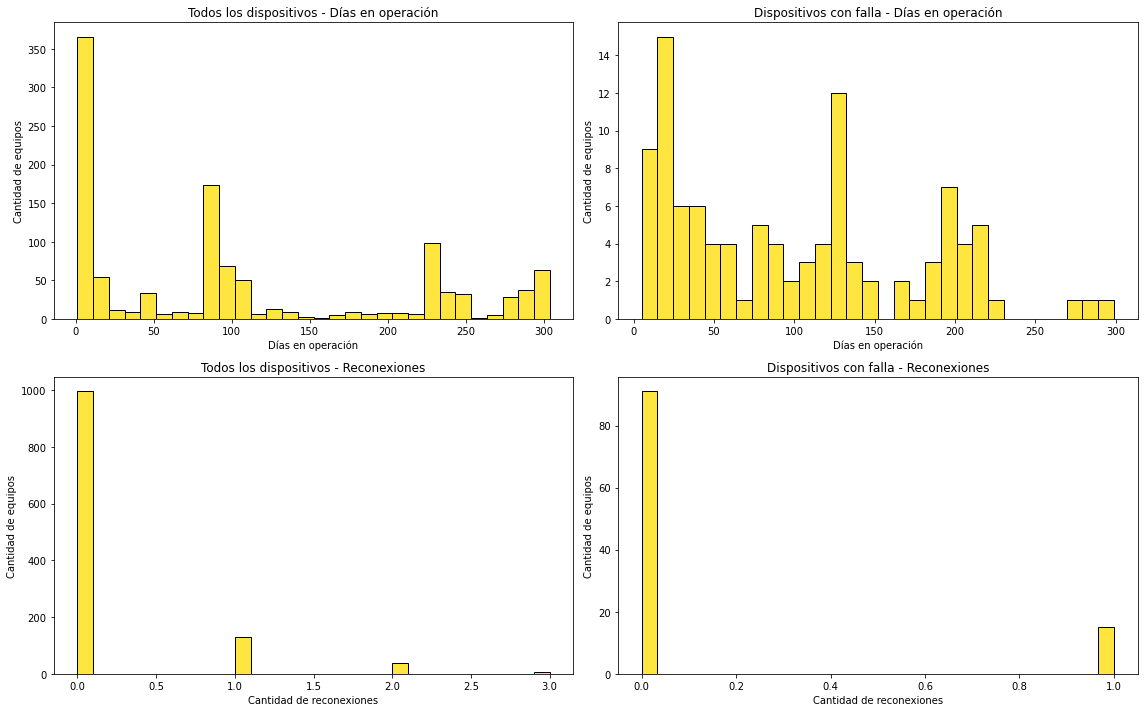

In [13]:
# Ordena para cálculo sequencial correto
df = df.sort_values(['device', 'date'])

# Cria op_period: contador de dias operando por dispositivo
df['op_period'] = df.groupby('device').cumcount() + 1

# Cria coluna auxiliar para detectar reconexões (gaps maiores que 1 dia)
df['prev_date'] = df.groupby('device')['date'].shift(1)
df['reconnected'] = (df['date'] - df['prev_date']).dt.days > 1

# Acumula número de reconexões por dispositivo
df['dev_reconnected'] = df.groupby('device')['reconnected'].cumsum().fillna(0).astype(int)

# Remove coluna auxiliar
df.drop(columns='prev_date', inplace=True)

# Agrupamentos para gráficos
dias_all = df.groupby('device').agg(days_work=('op_period', 'max'))
dias_fail = df[df['failure'] == 1].groupby('device').agg(days_work=('op_period', 'max'))

recon_all = df.groupby('device').agg(reconnect=('dev_reconnected', 'max'))
recon_fail = df[df['failure'] == 1].groupby('device').agg(reconnect=('dev_reconnected', 'max'))

fig, ax = plt.subplots(2, 2, figsize=(16, 10))

# 1 - Dias de operação - todos os dispositivos
sns.histplot(data=dias_all, x='days_work', bins=30, color='#FFDD00', edgecolor='black', ax=ax[0, 0])
ax[0, 0].set_title('Todos los dispositivos - Días en operación')
ax[0, 0].set_xlabel('Días en operación')
ax[0, 0].set_ylabel('Cantidad de equipos')

# 2 - Dias de operação - com falha
sns.histplot(data=dias_fail, x='days_work', bins=30, color='#FFDD00', edgecolor='black', ax=ax[0, 1])
ax[0, 1].set_title('Dispositivos con falla - Días en operación')
ax[0, 1].set_xlabel('Días en operación')
ax[0, 1].set_ylabel('Cantidad de equipos')

# 3 - Reconexões - todos os dispositivos
sns.histplot(data=recon_all, x='reconnect', bins=30, color='#FFDD00', edgecolor='black', ax=ax[1, 0])
ax[1, 0].set_title('Todos los dispositivos - Reconexiones')
ax[1, 0].set_xlabel('Cantidad de reconexiones')
ax[1, 0].set_ylabel('Cantidad de equipos')

# 4 - Reconexões - com falha
sns.histplot(data=recon_fail, x='reconnect', bins=30, color='#FFDD00', edgecolor='black', ax=ax[1, 1])
ax[1, 1].set_title('Dispositivos con falla - Reconexiones')
ax[1, 1].set_xlabel('Cantidad de reconexiones')
ax[1, 1].set_ylabel('Cantidad de equipos')

plt.tight_layout()
plt.show()


A partir del histograma (arriba a la izquierda), se observa que más de 350 dispositivos funcionaron menos de 10 días, lo cual indica una gran cantidad de equipos con vida útil extremadamente corta.

También se identifican dos concentraciones marcadas:

* Una entre **80 y 90 días**, posiblemente vinculada a ciclos de mantenimiento o recambios planificados.
* Otra entre **230 y 240 días**, lo que podría reflejar el agotamiento de la vida útil de ciertos dispositivos.

Además, unos 60 dispositivos alcanzaron entre 290 y 304 días de operación, lo que sugiere que una minoría se mantuvo activa durante casi todo el período observado.

En general, la mayoría de los dispositivos tuvieron ciclos operativos breves o medianos, con una clara tendencia al reemplazo o desconexión anticipada. Solo una pequeña fracción logró sostenerse en funcionamiento de forma prolongada.

----

#### 📈  Parte Ttemporal de los Datos

A continuación, vamos realizar algunos tratamientos relacionados con la parte temporal de los datos.

In [14]:
df = add_date_features(df)

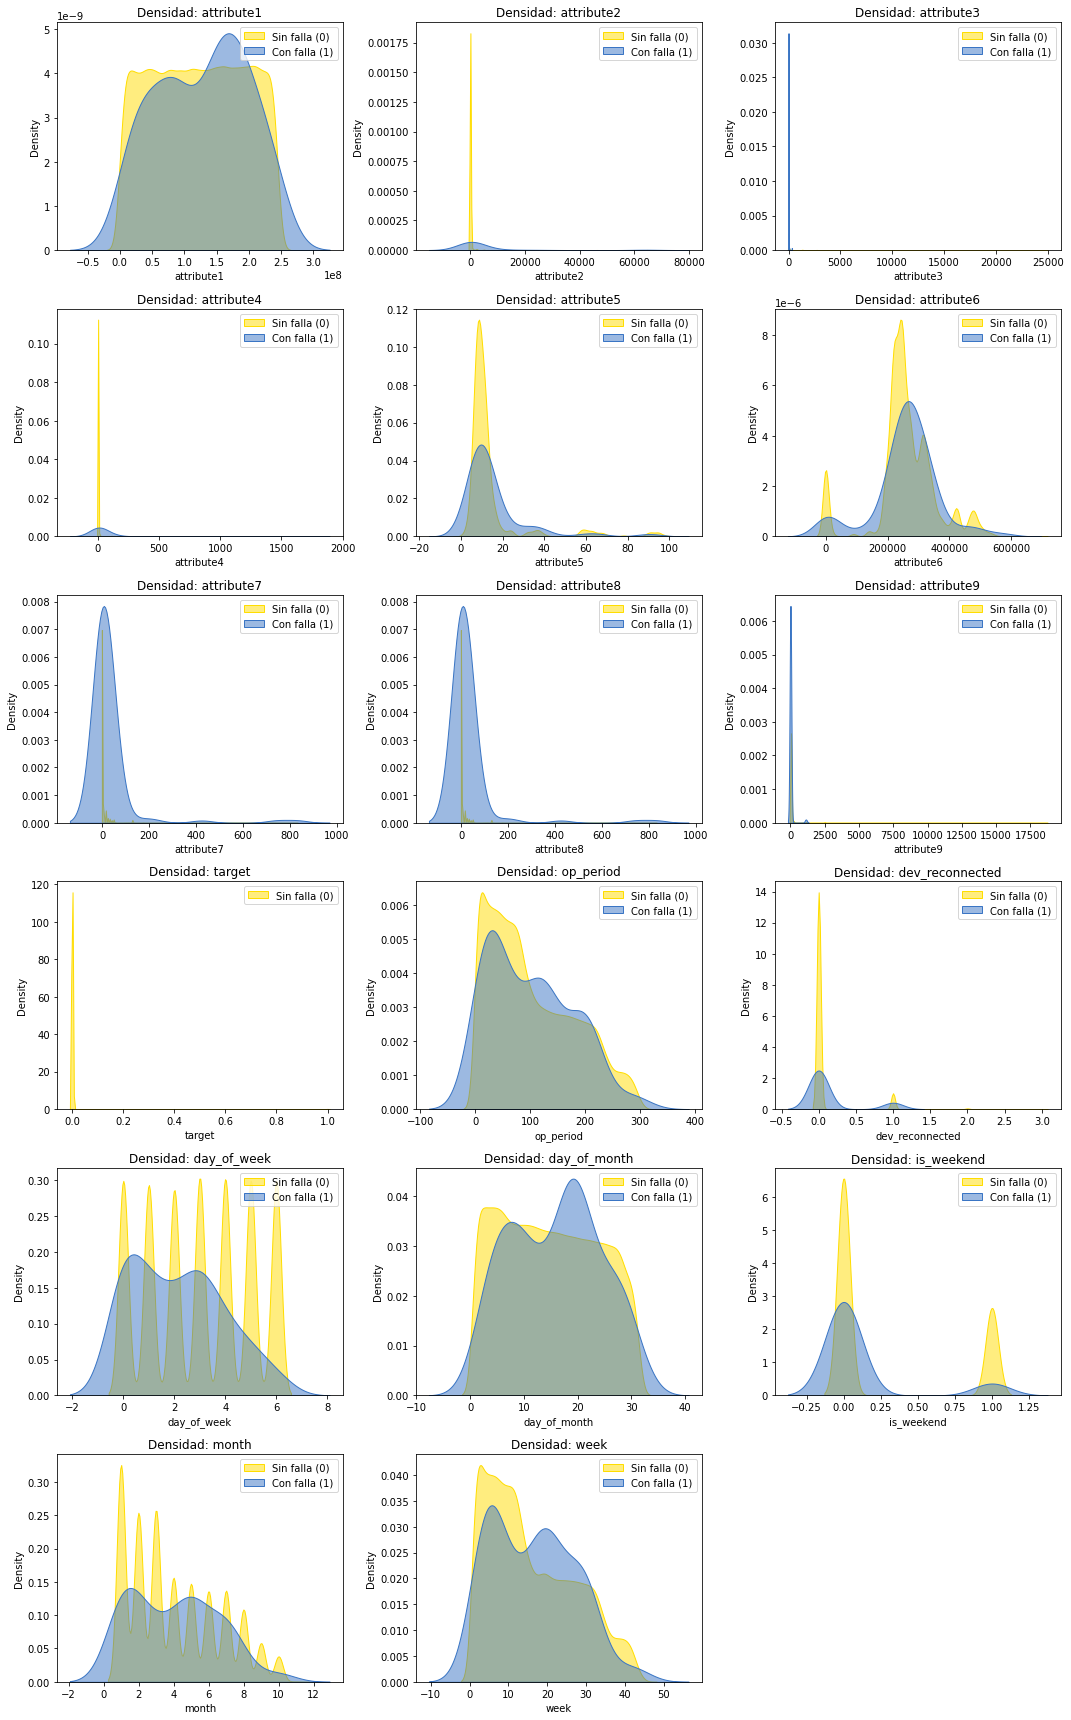

In [15]:
features = df.select_dtypes(include='number').columns.drop('failure')

# subplots
n = len(features)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  

for i, col in enumerate(features):
    ax = axes[i]
    sns.kdeplot(data=df[df['failure'] == 0], x=col, fill=True, common_norm=False,
                alpha=0.5, label='Sin falla (0)', color='#FFDD00', ax=ax)
    sns.kdeplot(data=df[df['failure'] == 1], x=col, fill=True, common_norm=False,
                alpha=0.5, label='Con falla (1)', color='#3A75C4', ax=ax)
    ax.set_title(f'Densidad: {col}')
    ax.legend()

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Las distribuciones de densidad muestran diferencias que, en muchos casos, no son del todo claras entre los dispositivos que fallaron y los que no. Algunas variables presentan cierta separación entre las curvas, pero en general hay bastante superposición, lo que indica un poder discriminativo limitado para varias de las features analizadas.

En cuanto a los días en operación y las reconexiones, se observa que la mayoría de los dispositivos tiene ciclos cortos y pocas interrupciones, aunque los que fallan tienden a mostrar una mayor variabilidad.


Si bien no se evidencian diferencias contundentes entre las clases, existen ciertos patrones que pueden ser aprovechados para desarrollar un modelo predictivo.

In [16]:
df.drop(['op_period', 'reconnected', 'dev_reconnected', 'device', 'date'], axis=1, inplace=True)

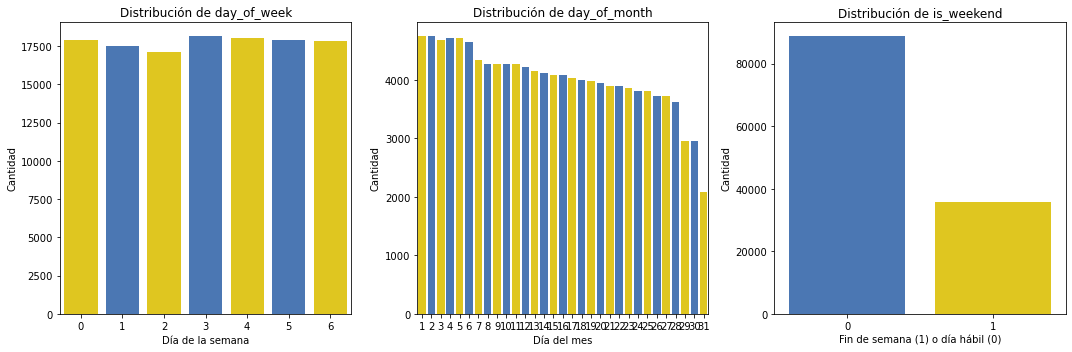

In [17]:
amarillo = '#FFDD00'
azul = '#3A75C4'

plt.figure(figsize=(15, 5))

# day_of_week
plt.subplot(131)
sns.countplot(data=df, x='day_of_week',
              palette=[amarillo if i % 2 == 0 else azul for i in range(df['day_of_week'].nunique())])
plt.title("Distribución de day_of_week")
plt.xlabel("Día de la semana")
plt.ylabel("Cantidad")

#  day_of_month
plt.subplot(132)
sns.countplot(data=df, x='day_of_month',
              palette=[amarillo if i % 2 == 0 else azul for i in range(df['day_of_month'].nunique())])
plt.title("Distribución de day_of_month")
plt.xlabel("Día del mes")
plt.ylabel("Cantidad")

# is_weekend
plt.subplot(133)
sns.countplot(data=df, x='is_weekend', palette=[azul, amarillo])
plt.title("Distribución de is_weekend")
plt.xlabel("Fin de semana (1) o día hábil (0)")
plt.ylabel("Cantidad")

plt.tight_layout()
plt.show()


La telemetría es estable de lunes a viernes y a principios de mes, pero disminuye progresivamente hasta el día 30 y casi desaparece los fines de semana. Esto revela puntos ciegos al final del ciclo mensual y los sábados/domingos, que requieren atención extra en un plan de mantenimiento predictivo.


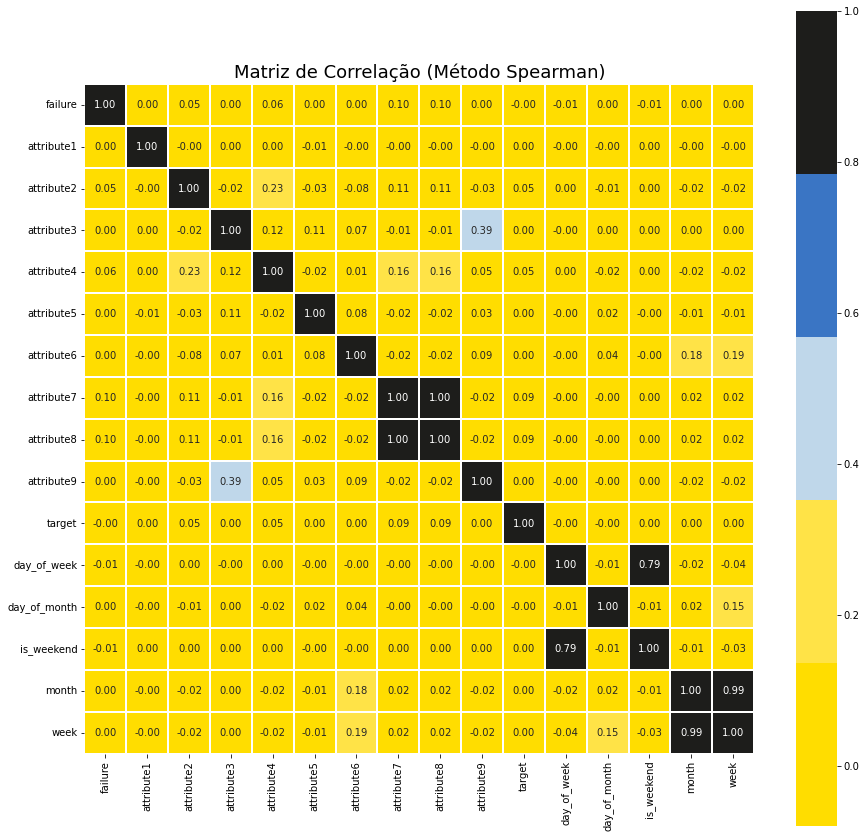

In [18]:
melii_cmap = sns.color_palette(['#FFDD00','#FFE347','#BFD7EA', '#3A75C4', '#1D1D1B'])

fig, axes = plt.subplots(1, figsize=(15, 15))
kendall_matrix = np.round(df.corr(method='spearman'), 2)

sns.heatmap(
    kendall_matrix,
    annot=True,
    linewidths=0.1,
    cmap=melii_cmap,  # paleta aplicada
    square=True,
    cbar=True,
    fmt=".2f",
    annot_kws={"size": 10}
)

plt.title("Matriz de Correlação (Método Spearman)", fontsize=18)
plt.show()


El atributo 7 y la métrica 8 tienen valores casi idénticos, por lo tanto, voy a eliminar la métrica 8.

In [19]:
df.drop('attribute8', axis=1,inplace=True)

Vamos a analizar los primeros cuatro caracteres de la columna `device_model`; por eso crearemos una nueva columna que extraiga esa porción del texto y facilite el análisis.

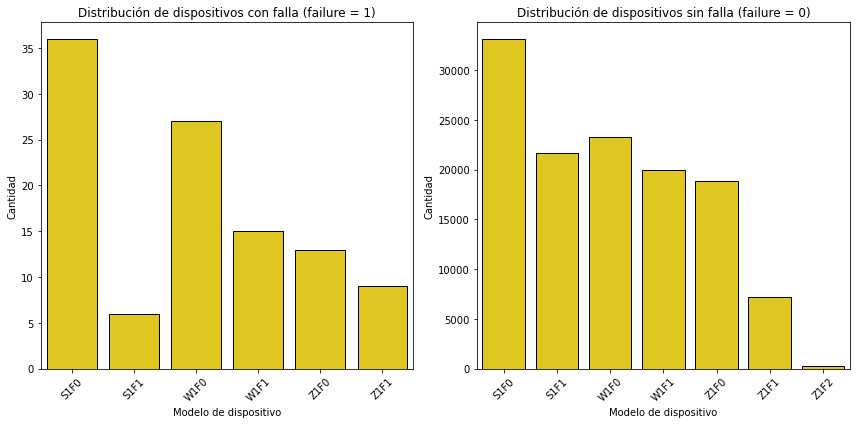

In [20]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
sns.countplot(x="device_model", data=df[df["failure"] == 1], color='#FFDD00', edgecolor='black')
plt.title('Distribución de dispositivos con falla (failure = 1)')
plt.xlabel('Modelo de dispositivo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)


plt.subplot(1, 2, 2)
sns.countplot(x="device_model", data=df[df["failure"] == 0], color=amarillo, edgecolor='black')
plt.title('Distribución de dispositivos sin falla (failure = 0)')
plt.xlabel('Modelo de dispositivo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()


Dado que el modelo **Z1F2** no aparece en la variable objetivo (es decir, no presenta ninguna falla), se puede eliminar del conjunto de datos para mejorar los resultados del modelo.


In [21]:
df = df[df['device_model'] != 'Z1F2']
#------
df.drop(columns=['failure'], inplace=True)
df.reset_index(drop=True, inplace=True)
#-------
df.tail()


,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,target,device_model,day_of_week,day_of_month,is_weekend,month,week
124237,193955488,0,0,0,7,264217,0,0,0.0,Z1F1,4,26,0,6,26
124238,153482784,0,0,0,7,265316,0,0,0.0,Z1F1,5,27,1,6,26
124239,155789448,0,0,0,7,265316,0,0,0.0,Z1F1,6,28,1,6,26
124240,24092712,0,0,0,7,265316,0,0,1.0,Z1F1,0,29,0,6,27
124241,178051496,0,0,0,7,265316,0,0,NaN,Z1F1,1,30,0,6,27


## 🧩 Parte 2: Procesamiento de Datos para el Modelado


En esta parte vamos a preparar la base para el modelado y el ajuste del modelo predictivo.


In [22]:
df = pd.get_dummies(df,drop_first=True)
df.tail()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,target,day_of_week,day_of_month,is_weekend,month,week,device_model_S1F1,device_model_W1F0,device_model_W1F1,device_model_Z1F0,device_model_Z1F1
124237,193955488,0,0,0,7,264217,0,0,0.0,4,26,0,6,26,0,0,0,0,1
124238,153482784,0,0,0,7,265316,0,0,0.0,5,27,1,6,26,0,0,0,0,1
124239,155789448,0,0,0,7,265316,0,0,0.0,6,28,1,6,26,0,0,0,0,1
124240,24092712,0,0,0,7,265316,0,0,1.0,0,29,0,6,27,0,0,0,0,1
124241,178051496,0,0,0,7,265316,0,0,NaN,1,30,0,6,27,0,0,0,0,1


A continuación, dividiremos el DataFrame en una parte que contiene la variable `target` y otra que no la incluye; luego balancearemos el conjunto reduciendo la clase mayoritaria al tamaño de la minoritaria y normalizaremos los datos.


In [ ]:
X = df.copy()
X = X.dropna()

#--------------------
Y = X['target']
X.drop('target', axis=1, inplace=True)

In [24]:
X_res, y_res = undersample(X, Y)

In [25]:
x_train, x_test, y_train, y_test = split_and_normalize(X_res, y_res)

## 🧩 Parte 3: Ajuste del modelo


In [26]:
evaluate_classifiers(x_train, y_train, x_test, y_test, classifiers=None)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForest,0.837209,0.850000,0.809524,0.829268
1,GradientBoost,0.813953,0.842105,0.761905,0.800000
2,KNN,0.674419,0.629630,0.809524,0.708333
3,BernoulliNB,0.720930,0.764706,0.619048,0.684211
4,Regressão Log,0.674419,0.684211,0.619048,0.650000
5,SVM,0.534884,0.523810,0.523810,0.523810


## 🧩 Parte 4: Optimización de modelos

En esta sección, utilizaremos Optuna para ajustar los hiperparámetros de los clasificadores seleccionados, buscando maximizar la métrica F1 mediante validación cruzada. Cada función objetivo definirá el espacio de búsqueda para un modelo específico (Gradient Boosting, Random Forest y BernoulliNB), y al final recopilaremos los mejores parámetros y sus correspondientes scores.


In [27]:
gb_params,  gb_f1  = create_study(lambda t: objective_gb(t, x_train, y_train, x_test, y_test), n_trials=50)
rf_params,  rf_f1  = create_study(lambda t: objective_rf(t, x_train, y_train, x_test, y_test), n_trials=50)
bnb_params, bnb_f1 = create_study(lambda t: objective_bnb(t, x_train, y_train, x_test, y_test), n_trials=50)

gb_model, _  = train_model(gb_params,  GradientBoostingClassifier, x_train, y_train, x_test, y_test)
rf_model, _  = train_model(rf_params,  RandomForestClassifier,   x_train, y_train, x_test, y_test)
bnb_model, _ = train_model(bnb_params, BernoulliNB,            x_train, y_train, x_test, y_test)

#Ranking por F1
tuned_models = [
    ('GradientBoosting', gb_model,  gb_f1),
    ('RandomForest',     rf_model,  rf_f1),
    ('BernoulliNB',      bnb_model, bnb_f1)
]
tuned_models_sorted = sorted(tuned_models, key=lambda tpl: tpl[2], reverse=True)

print('Modelos tunados ranqueados por F1:')
for name, _, score in tuned_models_sorted:
    print(f" - {name}: {score:.4f}")

voting_clf = build_voting({n: m for n, m, _ in tuned_models_sorted}, voting='hard')
voting_clf.fit(x_train, y_train)
print("\nRelatório do Voting Classifier:")
print(classification_report(y_test, voting_clf.predict(x_test)))

Modelos tunados ranqueados por F1:
 - GradientBoosting: 0.9268
 - BernoulliNB: 0.7619
 - RandomForest: 0.7368

Relatório do Voting Classifier:
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91        22
         1.0       0.95      0.86      0.90        21

    accuracy                           0.91        43
   macro avg       0.91      0.91      0.91        43
weighted avg       0.91      0.91      0.91        43



In [ ]:
# Tunning
tuned_models = [
    ('GradientBoosting', gb_model),
    ('RandomForest',     rf_model),
    ('BernoulliNB',      bnb_model)
]

# Adiciona o VotingClassifier ao conjunto de modelos
tuned_models.append(('VotingClassifier', voting_clf))

# Calcula métricas de cada modelo no conjunto de teste
tuned_metrics = []
for name, model in tuned_models:
    y_pred = model.predict(x_test)
    tuned_metrics.append({
        'Model':     name,
        'Accuracy':  accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall':    recall_score(y_test, y_pred, zero_division=0),
        'F1-score':  f1_score(y_test, y_pred, zero_division=0)
    })

# Cria e exibe o DataFrame com as métricas
metrics_df = pd.DataFrame(tuned_metrics).sort_values(by='F1-score', ascending=False).reset_index(drop=True)
display(metrics_df)


,Model,Accuracy,Precision,Recall,F1-score
0,GradientBoosting,0.930233,0.950000,0.904762,0.926829
1,VotingClassifier,0.906977,0.947368,0.857143,0.900000
2,BernoulliNB,0.767442,0.761905,0.761905,0.761905
3,RandomForest,0.767442,0.823529,0.666667,0.736842


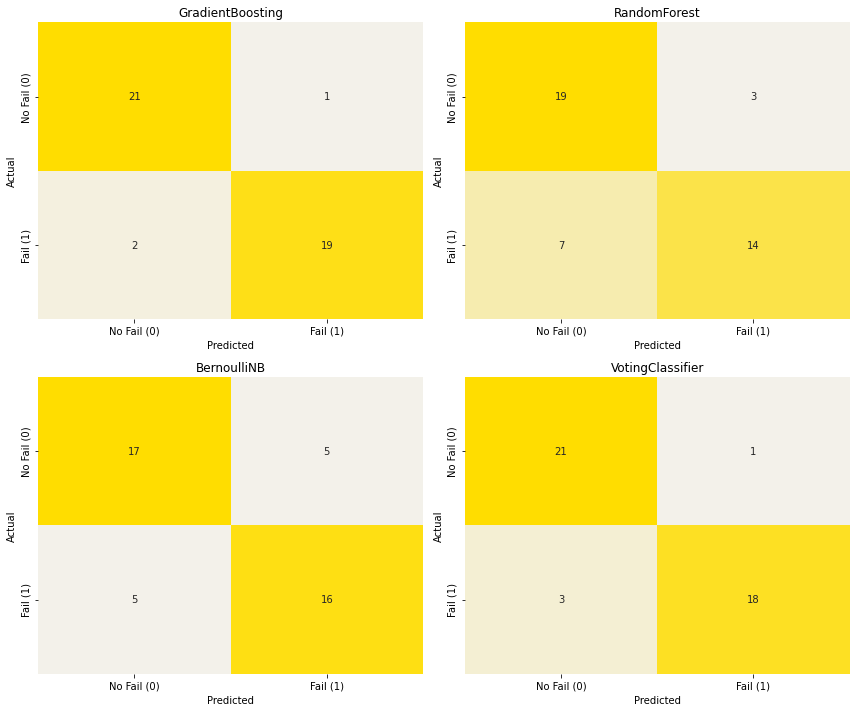

In [29]:
cmap_yellow = sns.light_palette('#FFDD00', as_cmap=True)

models = [
    ('GradientBoosting', gb_model),
    ('RandomForest',     rf_model),
    ('BernoulliNB',      bnb_model),
    ('VotingClassifier', voting_clf)
]

# Configura a figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, model) in zip(axes.flatten(), models):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cbar=False,
        cmap=cmap_yellow,
        ax=ax,
        xticklabels=['No Fail (0)', 'Fail (1)'],
        yticklabels=['No Fail (0)', 'Fail (1)']
    )
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


El modelo que mejor rendimiento mostró fue GradientBoosting, con Accuracy $93\%$, Precision $95\%$, Recall $90\%$ y F1-score $92,6\%$. En segundo lugar quedó VotingClassifier, con Accuracy $88,4\%$, Precision $86,4\%$, Recall $90,47\%$ y F1-score $88, 4\%$. Optaremos por **GradientBoosting** debido a la sutil mejora en el recall y lo utilizaremos para incorporar en la base la probabilidad de falla al día siguiente.


## 🧩 Parte 4: Cálculo de las Probabilidades de Fallos

In [30]:
best_model = tuned_models_sorted[0][1]

X_res, y_res = undersample(X, Y)  
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

scaler = StandardScaler().fit(X_train_df)
x_train = scaler.transform(X_train_df)
x_test  = scaler.transform(X_test_df)

probs_fail = best_model.predict_proba(x_test)[:, 1]
y_pred     = best_model.predict(x_test)

X_test_df = X_test_df.copy()
X_test_df['prob_failure'] = probs_fail
X_test_df['predicted_class'] = y_pred
X_test_df['true_class']      = y_test.values

# Compará las primeras filas
X_test_df[['prob_failure', 'predicted_class', 'true_class']].head(10)


,prob_failure,predicted_class,true_class
110120,0.290497,0.0,0.0
20417,0.297909,0.0,1.0
66644,0.461500,0.0,0.0
74236,0.957542,1.0,1.0
110879,0.164068,0.0,0.0
14139,0.574973,1.0,1.0
53985,0.497229,0.0,0.0
2750,0.043532,0.0,0.0
69953,0.983781,1.0,1.0
11583,0.196723,0.0,0.0



## 💡  Conclusión


Priorizamos maximizar el F1-score y sobre todo el recall– por dos motivos principales:

1. **Desbalance de clases**
   Nuestro conjunto de datos tiene muchos más días sin falla (clase 0) que con falla (clase 1). En ese escenario, la exactitud puede engañar (alcanzás alto porcentaje si siempre predecís “sin falla”). El F1-score, como media armónica entre precisión y recall, ofrece una mirada más justa en situaciones desbalanceadas.

2. **Alto costo de falsos negativos**
   Un falso negativo –no prever una falla que realmente ocurre puede derivar en paradas no planificadas, daños al equipo y costos muy elevados. Por eso elegimos un recall alto (capturar la mayoría de las fallas) aun sacrificando algo de precisión. Al optimizar el F1, conseguimos:

   * recall elevado $\to$ capturar la mayoría de las fallas futuras
   * precisión razonable $\to$ evitar alertas innecesarias

Al final, esta estrategia nos dio un modelo equilibrado y sensible a las fallas, justo lo que necesitábamos para la mantención predictiva.
